In [37]:
import pandas
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [38]:
# read the csv files
trainData = pandas.read_csv("NHANES_Data_P1_MI_train.csv")
testData = pandas.read_csv("NHANES_Data_P1_MI_test.csv")

In [39]:
# Remove rows that have missing "MI" and drop columns that are not needed
trainData = trainData.dropna(subset=["MI"])
trainData = trainData.drop(columns = ["ID", "Income", "Edu", "Insurance"])

In [40]:
# clean data
imputer = KNNImputer(n_neighbors=10)
imputerTrainData = imputer.fit_transform(trainData)
imputerTrainData = pandas.DataFrame(imputerTrainData, columns=trainData.columns)

In [41]:
# Prepare the data
x = imputerTrainData[["Sex", "Age", "Race", "Systolic", "Diastolic", "Pulse", "BMI", "HDL", "Trig", "LDL", "TCHOL", "eGFR", "CurrentSmoker", "Diabetes"]]
y = imputerTrainData[["MI"]]

In [42]:
# split the data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

In [43]:
# scale data using robustScaler
scaler = RobustScaler()
scaledXTrainData = scaler.fit_transform(xTrain)
scaledXTestData = scaler.transform(xTest)

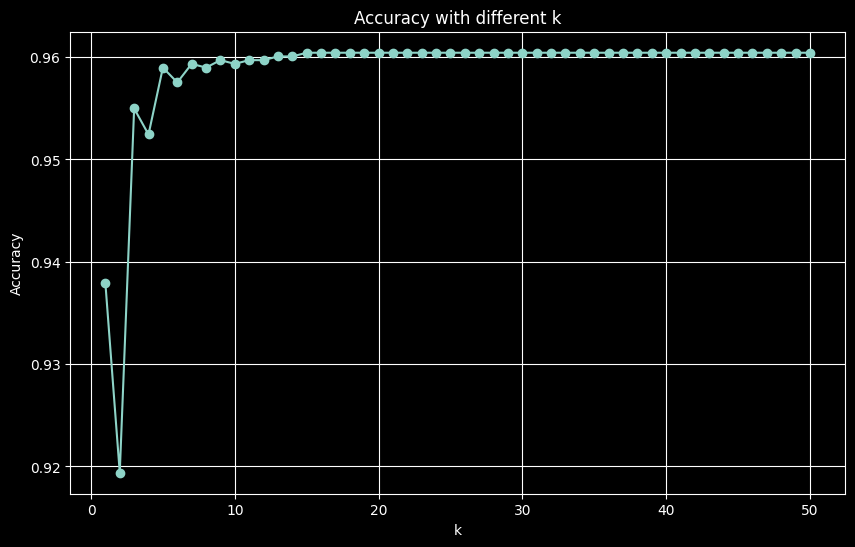

Best k value:  15 
Accuracy:  0.9604212055192447


In [ ]:
# find the best k value and plot the accuracies of eack k
kRange = range(1, 51)
accuracies = []
for k in kRange:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaledXTrainData, yTrain.values.ravel())
    score = knn.score(scaledXTestData, yTest.values.ravel())
    accuracies.append(score)

plt.style.use("dark_background")
plt.figure(figsize=(10,6))
plt.plot(kRange, accuracies,marker='o')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("Accuracy with different k")
plt.grid(True)
plt.show()

bestK = kRange[accuracies.index(max(accuracies))]
print(f'Best k value: ',bestK,'\nAccuracy: ', max(accuracies))

In [45]:
# create and train the model

# for distanc metrics i am going to use defualt minkowski
KNN = KNeighborsClassifier(n_neighbors=bestK)
KNN.fit(scaledXTrainData, yTrain.values.ravel())
pp = KNN.predict_proba(scaledXTestData)

print("score:", KNN.score(scaledXTestData, yTest.values.ravel()))
print("\n The predicted probability:\n", pp)

score: 0.9604212055192447

 The predicted probability:
 [[0.  1. ]
 [0.  1. ]
 [0.  1. ]
 ...
 [0.2 0.8]
 [0.2 0.8]
 [0.  1. ]]


In [46]:
# Impute missing values in testData

testData = testData.drop(columns = ["Income", "Edu", "Insurance"])
imputedTestData = imputer.fit_transform(testData)
imputedTestData = pandas.DataFrame(imputedTestData, columns=testData.columns)

In [47]:
# scale and predict test data

xTestData = imputedTestData[["Sex", "Age", "Race", "Systolic", "Diastolic", "Pulse", "BMI", "HDL", "Trig", "LDL", "TCHOL", "eGFR", "CurrentSmoker", "Diabetes"]]
scaledXTestDataForPrediction = scaler.transform(xTestData)
miProb = KNN.predict_proba(scaledXTestDataForPrediction)[:, 1]

In [48]:
# Add probability column and save to CSV

imputedTestData["ProbabilityMI"] = miProb
finalData = imputedTestData[["ID", "ProbabilityMI"]]
finalData.to_csv("test_with_prob.csv", index=False)